
# Nonlinear Equations


## Outline

1. Setup
2. Bisection method
3. Function iteration
4. Newton's method
5. Quasi-Newton method
6. Choosing a solution method
7. Convergence
8. Resources

## Setup

The nonlinear equation takes one of two forms.

* **Rootfinding problem** Given a function $f: R^n \mapsto R^n$,compute an $n$-vector $x^*$, called root of $f$, such that $f(x^*) = 0$.

* **Fixed-point problem** Given a function $g: R^n \mapsto R^n$, compute an $n$-vector $x^*$ called fixed point of $g$ such that $g(x^*) = x^*$

The wto forms are equivalent.

* A root of $f$ is a fixed-point of $g(x) = x - f(x)$.
* A fixed-point of $g$ is a root ot $f(x) = x - g(x)$.

Nonlinear equations arise naturally in economics:

* Multicommodity market equilibrium models
* Multiperson static game models 
* Unconstrained optimization models

Nonlinear equations also arise indirectly when numerically solving economic models involving functional equations:

* Dynamic optimization models 
* Rational expectations models 
* Arbitrage pricing models

In [1]:
from temfpy.nonlinear_equations import exponential  # noqa: F401
from scipy import optimize
import pandas as pd
import numpy as np

from nonlinear_algorithms import bisect
from nonlinear_plots import plot_bisection_test_function

from nonlinear_algorithms import fixpoint
from nonlinear_plots import plot_fixpoint_example
from nonlinear_plots import plot_newton_pathological_example
from nonlinear_plots import plot_convergence
from nonlinear_plots import plot_newtons_method
from nonlinear_plots import plot_secant_method

from nonlinear_algorithms import newton_method

from nonlinear_problems import bisection_test_function
from nonlinear_problems import function_iteration_test_function
from nonlinear_problems import newton_pathological_example

## Bisection method

We start with the implementation (and testing) of the bisection algorithm.


* The bisection method is perhaps the simplest and most robust method for computing the root of a continuous real-valued function defined on a bounded interval of the real line. The bisection method is based on the Intermediate Value Theorem, which asserts that if a continuous real-valued function defined on an interval assumes two distinct values, then it must assume all values in between. In particular, if $f$ is continuous, and $f (a)$ and $f (b)$ have different signs, then $f$ must have at least one root $x$ in $[a, b]$.

* Each iteration begins with an interval known to contain or to bracket a root of $f$ , because the function has different signs at the interval endpoints. The interval is bisected into two subintervals of equal length. One of the two subintervals must have endpoints of different signs and thus must contain a root of $f$. This subinterval is taken as the new interval with which to begin the subsequent iteration. In this manner, a sequence of intervals is generated, each half the width of the preceding one, and each known to contain a root of $f$ . The process continues until the width of the bracketing interval containing a root shrinks below an acceptable convergence tolerance.

In [2]:
??bisect

Signature: bisect(f, a, b, tolerance=1.5e-08)
Source:   
def bisect(f, a, b, tolerance=1.5e-8):
    """Apply bisect method to root finding problem.

    Iterative procedure to find the root of a continuous real-values function :math:`f(x)` defined
    on a bounded interval of the real line. Define interval :math:`[a, b]` that is known to contain
    or bracket the root of :math:`f` (i.e. the signs of :math:`f(a)` and :math:`f(b)` must differ).
    The given interval :math:`[a, b]` is then repeatedly bisected into subintervals of equal length.
    Each iteration, one of the two subintervals has endpoints of different signs (thus containing
    the root of :math:`f`) and is again bisected until the size of the subinterval containing the
    root reaches a specified convergence tolerance.

    Parameters
    ----------
    f : callable
        Continuous, real-valued, univariate function :math:`f(x)`.
    a : int or float
        Lower bound :math:`a` for :math:`x \\in [a,b]`.
    b : int

Let's visualize a test function to get a sense of what result can should expect.

In [3]:
??bisection_test_function

Signature: bisection_test_function(x)
Source:   
def bisection_test_function(x):
    """Get test function for bisection."""
    return x ** 3 - 2
File:      ~/Documents/Econ/ose/ose-course-scientific-computing/lectures/nonlinear_equations/nonlinear_problems.py
Type:      function


In [4]:
??plot_bisection_test_function

Signature: plot_bisection_test_function(f)
Source:   
def plot_bisection_test_function(f):
    """Plot bisect example."""
    fig, ax = plt.subplots()
    grid = np.linspace(1, 2)

    values = []
    for value in grid:
        values.append(f(value))
    ax.plot(grid, values)

    ax.axes.axhline(0, color="grey")
    ax.set_ylabel("f(x)")
    ax.set_xlabel("x")
File:      ~/Documents/Econ/ose/ose-course-scientific-computing/lectures/nonlinear_equations/nonlinear_plots.py
Type:      function


* The ability to vectorize functions using [np.vectorize](https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html) comes in very handy when evaluating functions over a grid. However, be aware that this is a simple replacement of a `for loop` and thus does not improve performance. 

We are ready to go ...

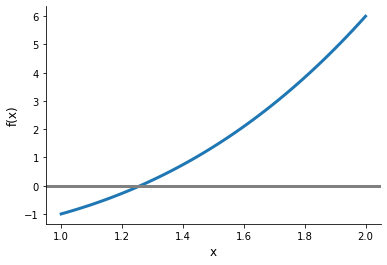

In [5]:
plot_bisection_test_function(bisection_test_function)

Now we are ready to check our implementation and investigate the sensitivity of results to alternative tuning parameter.

In [6]:
lower, upper = 1, 2
x, xvals = bisect(bisection_test_function, lower, upper)
print(f"The root of our test function is {x:3.2f}.")

The root of our test function is 1.26.


 <div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
      <li>Write a short test that ensures that in fact found a root of the function. </li>
      <li>Create a simple plot that shows each iterate of $x$ and label the two axis appropriately. </li>
    </ul> 
</div>


## Function iteration


* Function iteration is a relatively simple technique that may be used to compute a fixed point $x = g(x)$ of a function from $R^n$ to $R^n$. The technique is also applicable to a rootfinding problem $f(x) = 0$ by recasting it as the equivalent fixed-point problem $g(x) = x - f (x)$. Function iteration begins with the analyst supplying a guess $x^{(0)}$ for the fixed point of $g$. Subsequent iterates are generated using the simple iteration rule

$$
\begin{align*}
x^{(k+1)} \leftarrow g(x^{(k)})
\end{align*}
$$

Since $g$ is continuous, if the iterates converge, they converge to a fixed point of $g$.

In [7]:
??fixpoint

Signature: fixpoint(f, x0, tolerance=0.0001)
Source:   
def fixpoint(f, x0, tolerance=10e-5):
    """Compute fixed point using function iteration.

    Parameters
    ----------
    f : callable
        Function :math:`f(x)`.
    x0 : float
        Initial guess for fixed point (starting value for function iteration).
    tolerance : float
        Convergence tolerance (tolerance < 1).

    Returns
    -------
    x : float
        Solution of function iteration.

    Examples
    --------
    >>> import numpy as np
    >>> x = fixpoint(f=lambda x : x**0.5, x0=0.4, tolerance=1e-10)[0]
    >>> np.allclose(x, 1)
    True

    """
    e = 1
    xvals = [x0]

    while e > tolerance:
        # Fixed point equation.
        x = f(x0)
        # Error at the current step.
        e = np.linalg.norm(x0 - x)
        x0 = x
        xvals.append(x0)
    return x, np.array(xvals)
File:      ~/Documents/Econ/ose/ose-course-scientific-computing/lectures/nonlinear_equations/nonlinear_algorithms.py
Ty

Let's visualize a test function to get a sense of what result can should expect.


In [8]:
??function_iteration_test_function

Signature: function_iteration_test_function(x)
Source:   
def function_iteration_test_function(x):
    """Get test function for function iteration."""
    return np.sqrt(x)
File:      ~/Documents/Econ/ose/ose-course-scientific-computing/lectures/nonlinear_equations/nonlinear_problems.py
Type:      function


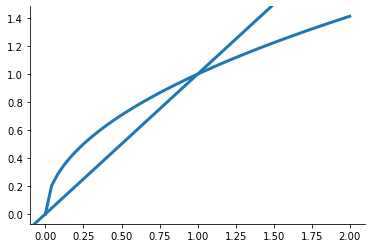

In [9]:
plot_fixpoint_example(function_iteration_test_function)

Let's run and test our implementation.

In [10]:
x = fixpoint(function_iteration_test_function, 0.4, tolerance=1e-5)[0]

try:
    np.testing.assert_almost_equal(function_iteration_test_function(x), x)
except AssertionError as msg:
    print(msg)


Arrays are not almost equal to 7 decimals
 ACTUAL: 0.9999965046343594
 DESIRED: 0.9999930092809364


* This is an example of using a try-except block to explicitly handle the `AssertionError`. Details on exception handling in Python, see this [Wiki](https://wiki.python.org/moin/HandlingExceptions) for some more examples. 

We set two parameters manually, which one is it? How about choosing different starting values?

In [11]:
for x0 in np.linspace(0.1, 0.9):
    x = fixpoint(function_iteration_test_function, x0, tolerance=1e-5)[0]
    try:
        np.testing.assert_almost_equal(function_iteration_test_function(x), x)
        print("Success for x0 {x0}")
    except AssertionError:
        pass

Let's look at the `tolerance` setting instead.

 <div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
      <li>Find the fixpoint of $g(x) = \sqrt{x + 0.2}$. </li>
      <li>How many iterations does the function iteration need? Does it depend on the starting value? </li>
    </ul> 
</div>


## Newton's method


Newton's method is an algorithm for computing the root of a function $f : R^n \mapsto R^n$.  Guess an initial value $x_0$ and successively form the iterates below until the iterate converge.

$$
\begin{align*}
x_{k + 1} = x_k - f^\prime(x_k)^{-1} f(x_k)
\end{align*}
$$

If $n = 1$, the iteration rule takes the simpler form 

$$
\begin{align*}
x_{k + 1} = x_k - \frac{f(x_k)}{f^\prime(x_k)}.
\end{align*}
$$

Newton's method employs a strategy of successive linearization. The strategy calls for the nonlinear function $f$ to be approximated by a sequence of linear functions whose roots are easily computed and, ideally, converge to the root of $f$. In particular, the $k + 1^{th}$ iterate 

$$
\begin{align*}
x_{k+1} = x_k - f^\prime(x_k)^{-1}f(x_k) 
\end{align*}
$$

is the root of the Taylor linear approximation of $f$ around the preceding iterate $x_k$.

$$
\begin{align*}
f(x) \approx f(x_k) + f^\prime(x_k)(x - x_k).
\end{align*}
$$


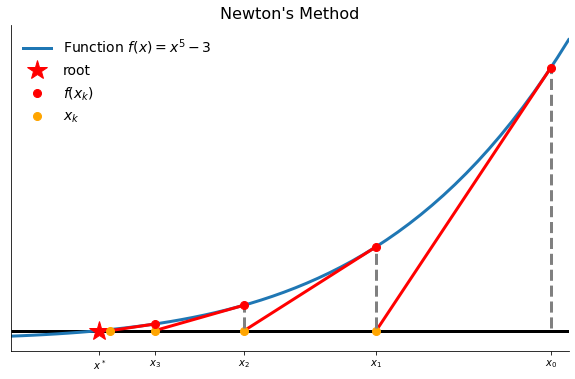

In [12]:
plot_newtons_method()

 <div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
      <li>Plot the function $f(x) = x^4 - 2$ and provide a rough estimate of its fix point. </li>
      <li>Let's compute the root of the function using Newton's method by employing the proper iteration rule: $$\begin{align*}
x_{k + 1} = x_k - \frac{f(x_k)}{f^\prime(c_k)} = x_k - \frac{x^4_k - 2}{4x^3_k}
\end{align*}$$
         </li>
    </ul> 
</div>




Let' look at a more general implementation.

In [13]:
??newton_method

Signature: newton_method(f, x0, tolerance=1.5e-08)
Source:   
def newton_method(f, x0, tolerance=1.5e-8):
    """Apply Newton's method to solving nonlinear equation.

    Solve equation using successive linearization, which replaces the nonlinear problem
    by a sequence of linear problems whose solutions converge to the solution of the nonlinear
    problem.

    Parameters
    ----------
    f : callable
        (Univariate) function :math:`f(x)`.
    x0 : float
        Initial guess for the root of :math:`f`.
    tolerance : float
        Convergence tolerance.

    Returns
    -------
    xn : float
        Solution of function iteration.

    """
    x0 = np.atleast_1d(x0)

    # This is tailored to the univariate case.
    assert x0.shape[0] == 1

    xn = x0.copy()

    while True:
        fxn, gxn = f(xn)
        if np.linalg.norm(fxn) < tolerance:
            return xn
        else:
            xn = xn - fxn / gxn
File:      ~/Documents/Econ/ose/ose-course-scientific-computin

 <div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>Whare are the important generalizations?</li>
    </ul> 
</div>

Let' explore one last test function to test the interface of our function and learn something about [private functions](https://dbader.org/blog/meaning-of-underscores-in-python) in the process.

$$
\begin{align*}
f(x) = x^3 - 2
\end{align*}
$$

In [14]:
def _jacobian(x):
    return 3 * x ** 2


def _value(x):
    return x ** 3 - 2


def f(x):
    return _value(x), _jacobian(x)


x = newton_method(f, 0.4)
np.testing.assert_almost_equal(f(x)[0], 0)

A potential shortcoming of Newton's method  is that the derivatives required for the Jacobian may not be available may be difficult to calculate analytically, or time-consuming to approximate numerically ... or that it might actually fail or result in cycles.

Consider the following pathological example which has a unique root at $0$.

$$
\begin{align*}
f(x) = x^{\frac{1}{3}} \, e^{-x^2}
\end{align*}
$$

In [15]:
??newton_pathological_example

Signature: newton_pathological_example(x)
Source:   
def newton_pathological_example(x):
    """Get Newton Pathological example."""
    fval = newton_pathological_example_fval(x)
    fjac = newton_pathological_example_fjac(x, newton_pathological_example_fval)
    return fval, fjac
File:      ~/Documents/Econ/ose/ose-course-scientific-computing/lectures/nonlinear_equations/nonlinear_problems.py
Type:      function


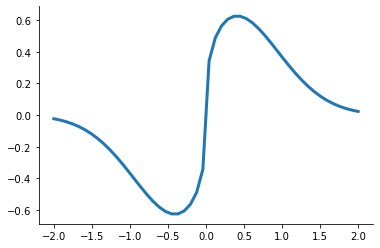

In [16]:
plot_newton_pathological_example(newton_pathological_example)

We can derive the Newton iterates as:

$$
\begin{align*}
x_{n + 1} = x_n\left(1 - \frac{3}{1 - 6 x_n^2 }\right)
\end{align*}
$$

 <div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li> What happens when you apply Newton's method to solve this function for different starting values?</li>
  <li> How does the Newton iterate look like for very small and very large values?</li>
    </ul> 
</div>

Another problems might be cycles.

<img src="material/fig-newton-cycles.png" width=600 height=600 />


## Quasi-Newton method


Quasi-Newton methods replace the Jacobian in Newton’s method with an estimate that is easier to compute. Specifically, quasi-Newton methods use an iteration rule

$$
\begin{align*}
x_{k+1} = x_k - A^{-1}_k f(x_k)
\end{align*}
$$

where $A_k$ is an estimate of the Jacobian $f^\prime(x_k)$. 

The **secant method** replaces the derivative in Newton’s method with the estimate

$$
\begin{align*}
f^\prime(x_k) \approx \frac{f(x_k) - f(x_{k-1})}{x_k - x_{k-1}}
\end{align*}
$$

The secant method is so called because it approximates the function $f$ using *secant* lines drawn through successive pairs of points on its graph.

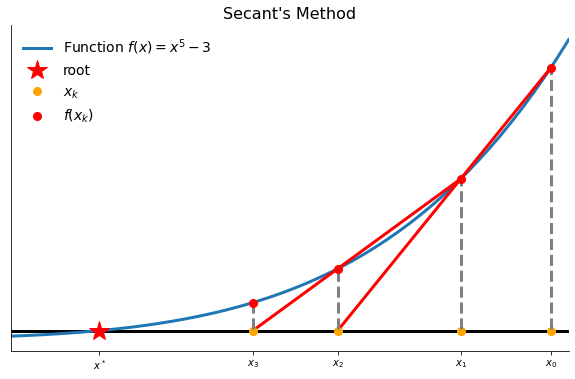

In [17]:
plot_secant_method()

Let's start with a crude implementation to make sure we understood the setup correctly. We will use this to show the `lambda` functions, see [here](https://realpython.com/python-lambda/https://realpython.com/python-lambda/) for details.

In [18]:
f = lambda z: z ** 4 - 2  # noqa: E731
x, xlag = 2.3, 2.4

for it in range(50):
    d = (f(x) - f(xlag)) / (x - xlag)
    x, xlag = x - f(x) / d, x
    if abs(x - xlag) < 1.0e-10:
        break

print(f"Root of our example function {x:5.3f}")

Root of our example function 1.189


**Broyden’s method** is the most popular multivariate generalization of the univariate secant method. **Broyden’s method** replaces the Jacobian in Newton’s method with an estimate $A_k$ that is updated by making the smallest possible change (measured by the Frobenius norm) that is consistent with the secant condition:

$$
\begin{align*}
f(x_{k + 1}) - f(x_k) = A_{k+1} (x_{k+1} - x_k ).
\end{align*}
$$
This yields the iteration rule
$$
\begin{align*}
A_{k+1} = A_k + (f(x_{k+1}) - f(x_k ) - A_k d_k)\frac{d^\prime_k}{d^\prime_k d_k}
\end{align*}
$$
where $d_k = x_{k+1} - x_k$. Often $A_0$ is equal to the numerical approximation of $f$ at $x_0$. The remarkable feature of Broyden's method is that it is able to generate a reasonable approximation to the Jacobian matrix with no additional evaluations of the function. This approach is readily available in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.broyden1.html).




In [19]:
rslt = optimize.root(f, 1.0, method="broyden1")
print(f"Root of our example function {rslt['x']:5.3f}")

Root of our example function 1.189


#### Cournot problem

Consider a market with two firms producing the same good. Firm $i$'s total cost of production is a function of the quantity $q_i$ it produces.

$$
\begin{align*}
C_i(q_i) = \frac{\beta_i}{2} q_i^2
\end{align*}
$$
The market clearing price is a function of the total quantity produced by both firms.
$$
\begin{align*}
P(q_1 + q_2) = (q_1 - q_2)^{-\alpha}
\end{align*}
$$
Firm $i$ chooses production $q_i$ so as to maximize its profit taking the other firm's output as given.
$$
\begin{align*}
\pi_i (q_1 , q_2 ) = P (q_1 + q_2 )q_i - C_i (q_i ).
\end{align*}
$$
Thus in equilibrium,
$$
\begin{align*}
\frac{\partial \pi_i}{\partial q_i} = (q_1 - q_2)^{-\alpha} - \alpha (q_1 + q_2)^{-(\alpha + 1) } q_i  - \beta_i q_i = 0\qquad\text{for}\quad i = 1, 2.
\end{align*}
$$

 <div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
      <li>Compute the market equilibrium quantities using Broyden's method for $\alpha =  0.6$ and $\beta= [0.6, 0.8]$.</li>
    </ul> 
</div>




<img src="material/fig-convergence-path.png" width=600 height=600 />


## Choosing a solution method



We now consider a more challenging task and compare the performance of `scipy`'s root finding algorithms. We will use one of [temfpy](https://temfpy.readthedocs.io/en/latest/index.html)'s test functions for this.

In [20]:
??exponential

Signature: exponential(x, a=10, b=1, jac=False)
Source:   
def exponential(x, a=10, b=1, jac=False):
    r"""Exponential function.

    .. math::
        x &\mapsto \begin{pmatrix} F_1(x) & F_2(x) & \dots & F_p(x) \end{pmatrix}^T \\
        F_1(x) &= e^{x_1} - b \\
        F_i(x) &= \frac{i}{a} (e^{x_i} +x_{i-1}) - b \\
        & \quad i = 2,3, \dots, p

    Parameters
    ----------
    x : array_like
        Input domain with dimension :math:`p`.
    a : float, optional
        The default value is 10.
    b : float, optional
        The default value is 1.
    jac : bool
          If True, an additional array containing the numerically
          and the analytically derived jacobian are returned.
          The default is False.

    Returns
    -------
    array_like
        Output domain
    array_like
        Only if :math:`jac = True`.
        Tuple containing the analytically derived Jacobian and the
        numerically derived Jacobian.

    References
    ----------
    .. [V2

Now let's see which of the algorithms performs best for a ten dimensional problem.

In [21]:
METHODS = ["broyden1", "broyden2", "anderson", "Krylov"]
DIMENSION = 10
PROBLEMS = 5

We are ready to run our benchmarking exercise.

In [22]:
def exponential_function(x):

    x = np.atleast_1d(x)

    p = x.shape[0]
    rslt = np.tile(np.nan, p)

    for i in range(p):
        xi = np.clip(x[i], None, 300)
        if i == 0:
            rslt[i] = np.exp(xi) - 1
        else:
            rslt[i] = (i / 10) * (np.exp(xi) + x[i - 1] - 1)

    return rslt


np.testing.assert_almost_equal(exponential_function([0, 0]), [0.0] * 2)

columns = ["Algorithm", "Sample", "Success", "Iteration"]
df = pd.DataFrame(columns=columns)

for method in METHODS:

    # Ensure that all have same test problems.
    np.random.seed(123)

    for _ in range(PROBLEMS):

        x0 = np.random.uniform(size=DIMENSION)

        rslt = optimize.root(exponential_function, x0, method=method)

        info = [[method, _, rslt["success"], rslt["nit"]]]
        df = df.append(pd.DataFrame(info, columns=columns), ignore_index=True)

/home/xxx/bin/anaconda3/envs/ose-course-scientific-computing/lib/python3.8/site-packages/scipy/optimize/nonlin.py:1001: RuntimeWarning: invalid value encountered in true_divide
  d = v / vdot(df, v)
/home/xxx/bin/anaconda3/envs/ose-course-scientific-computing/lib/python3.8/site-packages/scipy/optimize/nonlin.py:1001: RuntimeWarning: divide by zero encountered in true_divide
  d = v / vdot(df, v)
/home/xxx/bin/anaconda3/envs/ose-course-scientific-computing/lib/python3.8/site-packages/scipy/optimize/nonlin.py:771: RuntimeWarning: invalid value encountered in multiply
  self.collapsed += c[:,None] * d[None,:].conj()


Now we can explore the performance of the alternative implementations.

In [23]:
df.head()

,Algorithm,Sample,Success,Iteration
0,broyden1,0,False,1100
1,broyden1,1,False,1100
2,broyden1,2,False,1100
3,broyden1,3,False,1100
4,broyden1,4,False,1100



## Convergence
        

Two factors determine the speed with which a properly coded and initiated algorithm will converge to a solution:

* Asymptotic rate of convergence
* Computational effort per iteration

The asymptotic rate of convergence measures improvement afforded per iteration near the solution. A sequence $x_k$ converges to $x^*$ at an asymptotic rate of order $p$ if there is constant $C > 0$ such that for $k$ sufficiently large,
$$
\begin{align*}
||x_{k+1} - x^* || \leq C ||x_k - x^* || p
\end{align*}
$$
* Function iteration converges at a “linear” rate with $p = 1$ and $C < 1$ 
* Broyden’s method converges at a “superlinear” rate with $p \approx 1.62$
* Newton’s method converges at a “quadratic” rate with $p = 2$

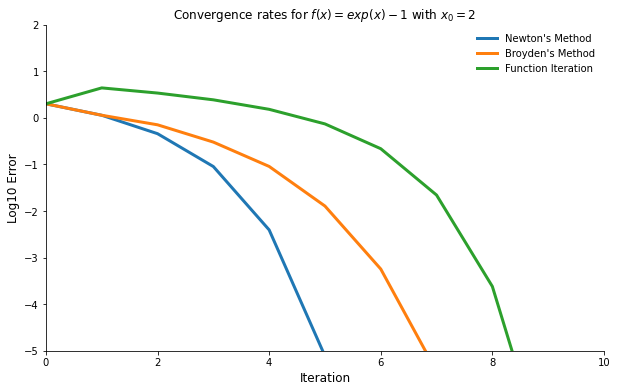

In [24]:
plot_convergence()

However, algorithms differ in computations per iteration.

* Function iteration requires a function evaluation.
* Broyden’s method additionally requires a linear solve.
* Newton’s method additionally requires a Jacobian evaluation.

Thus, a faster rate of convergence typically can be achieved only by investing greater computational effort per iteration. The optimal tradeoff between rate of convergence and computational effort per iteration varies across applications.

## Resources

#### Software

* **HOMPACK**: https://www.netlib.org/hompack